In [1]:
import matplotlib.pyplot as plt
import torch

from torch.nn import ModuleList, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

from data import BinaryColoredMNIST

from models import MLPEncoder, ConvEncoder, Classifier, Adversary

from train import train_laftr

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


### Data Modification

In [3]:
data_dir = "data/mnist_data"
train_set = BinaryColoredMNIST(root=data_dir, p_even_red=0.8, p_odd_red=0.7, prob_a=0.5)

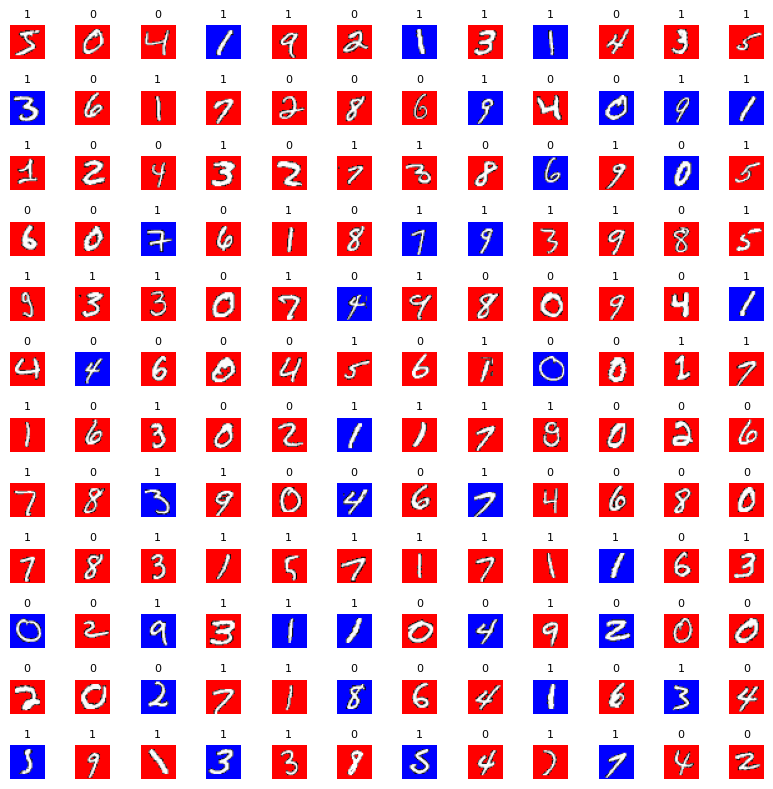

In [4]:
data = train_set[:144]

plt.figure(figsize=(8, 8))

for i, (img, a, label) in enumerate(data):
    plt.subplot(12, 12, i + 1)
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.title(str(label.item()), fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [5]:
# Setup for DP

C = 2
learning_rate = 1e-2
gamma = 100 / C

encoder = MLPEncoder(10).to(device)
classifier = Classifier(10).to(device)
adv = Adversary(10).to(device)

adversaries = ModuleList([adv for _ in range(C)])

criterion_class = CrossEntropyLoss()

optimizer_enc_class = Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=learning_rate)

optimizer_adv = Adam(adv.parameters(), lr=learning_rate / C)
optimizers_adv = [optimizer_adv for _ in range(C)]

train_loader  = DataLoader(train_set, batch_size=256, shuffle=True)

In [6]:
losses_enc, losses_adv = train_laftr(encoder, classifier, adversaries, criterion_class, optimizer_enc_class, optimizers_adv, train_loader, gamma, device=device, verbose=True)

Epoch 1/12:   0%|          | 0/235 [00:00<?, ?batch/s]

Epoch 0 (encoder+classifier loss: -98.5573, adversary loss: 2.0201)


Epoch 2/12:   0%|          | 0/235 [00:00<?, ?batch/s]

Epoch 1 (encoder+classifier loss: -99.7074, adversary loss: 2.0000)


Epoch 3/12:   0%|          | 0/235 [00:00<?, ?batch/s]

Epoch 2 (encoder+classifier loss: -99.7432, adversary loss: 2.0000)


Epoch 4/12:   0%|          | 0/235 [00:00<?, ?batch/s]

Epoch 3 (encoder+classifier loss: -99.2333, adversary loss: 2.0000)


Epoch 5/12:   0%|          | 0/235 [00:00<?, ?batch/s]

Epoch 4 (encoder+classifier loss: -99.6183, adversary loss: 2.0000)


Epoch 6/12:   0%|          | 0/235 [00:00<?, ?batch/s]

Epoch 5 (encoder+classifier loss: -99.7538, adversary loss: 2.0000)


Epoch 7/12:   0%|          | 0/235 [00:00<?, ?batch/s]

Epoch 6 (encoder+classifier loss: -99.7746, adversary loss: 2.0000)


Epoch 8/12:   0%|          | 0/235 [00:00<?, ?batch/s]

Epoch 7 (encoder+classifier loss: -99.7929, adversary loss: 2.0000)


Epoch 9/12:   0%|          | 0/235 [00:00<?, ?batch/s]

Epoch 8 (encoder+classifier loss: -99.8116, adversary loss: 2.0000)


Epoch 10/12:   0%|          | 0/235 [00:00<?, ?batch/s]

Epoch 9 (encoder+classifier loss: -99.8285, adversary loss: 2.0000)


Epoch 11/12:   0%|          | 0/235 [00:00<?, ?batch/s]

Epoch 10 (encoder+classifier loss: -99.8388, adversary loss: 2.0000)


Epoch 12/12:   0%|          | 0/235 [00:00<?, ?batch/s]

Epoch 11 (encoder+classifier loss: -99.8633, adversary loss: 2.0000)


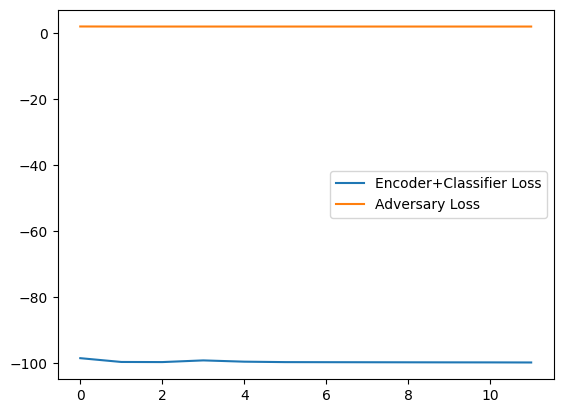

In [7]:
plt.plot(losses_enc, label="Encoder+Classifier Loss")
plt.plot(losses_adv, label="Adversary Loss")

plt.legend()
plt.show()

In [8]:
test_set = BinaryColoredMNIST(root=data_dir, p_even_red=0.8, p_odd_red=0.7, prob_a=0.5, train=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

y_pred = []
y_true = []
a_pred = []
a_true = []

for (x, a, y) in test_loader:
    x = x.to(device)
    a = a.to(device)
    y = y.to(device)

    z = encoder(x)
    
    y_preds = classifier(z).argmax(dim=1)

    for y_i in range(C):
        mask = y == y_i
        if mask.any():
            adv = adversaries[y_i]
            a_pred.append(adv(z[mask]).argmax(dim=1).cpu())
            a_true.append(a[mask].cpu())

    y_pred.append(y_preds.cpu())
    y_true.append(y.cpu())

a_pred = torch.cat(a_pred, dim=0).numpy()
a_true = torch.cat(a_true, dim=0).numpy()

y_pred = torch.cat(y_pred, dim=0).numpy()
y_true = torch.cat(y_true, dim=0).numpy()

In [9]:
from sklearn.metrics import classification_report

print("Classifier:")
print(classification_report(y_true, y_pred))

print()
print()

print("Adversary:")
print(classification_report(a_true, a_pred))

Classifier:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      4926
           1       0.92      0.97      0.94      5074

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



Adversary:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7499
           1       0.25      1.00      0.40      2501

    accuracy                           0.25     10000
   macro avg       0.13      0.50      0.20     10000
weighted avg       0.06      0.25      0.10     10000



/Users/vicentin/.pyenv/versions/telecom-paris/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vicentin/.pyenv/versions/telecom-paris/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vicentin/.pyenv/versions/telecom-paris/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera